In [1]:
clean_up = True
%run stdPackages.ipynb

The file _gams_py_gdb0.gdx is still active and was not deleted.
The file _gams_py_gdb1.gdx is still active and was not deleted.
The file _gams_py_gdb3.gdx is still active and was not deleted.
The file _gams_py_gdb4.gdx is still active and was not deleted.


In [2]:
ws = gams.GamsWorkspace(working_directory=d['work']) # specify where you want to run the GAMS models from (here the repository referred to in d['work'])

Load standard settings:

In [3]:
name = 'A' # name of model
module = name+'Trade'
db_IO = GpyDB(f"{d['data']}\\IO_{name}") # load IO database named IO_name
with open(f"{d['data']}\\glob_{name}","rb") as file: # load global settings anmed glob_name
    glob=pickle.load(file)

For the simple armington module to work, we need to supply:
* IO mapping from domestic to foreign goods: ```dom2for[n,nn]``` (global).
* Mapping from foreign sector to domestic goods: ```sfor_ndom[s,n]``` (local).
* The subset of foreign goods that are substitutes to the domestic ones in ```sfor\_ndom[s,n]```: ```nOut_f[n]``` (local). This subset is implied by ```sfor_ndom``` and ```dom2for```.

Here, we load data on armington elasticities and use this to back out the mapping ```sfor_ndom```: 

In [4]:
otherData = read.SeriesDB_from_wb(f"{d['data']}\\A_Trade.xlsx", {'variables': ['vars']})

Subset the IO data to only keep the sectors that are in this data set:

In [5]:
aggregateDB.subset_db(db_IO, otherData['sigma'].index.levels[0]) # Keep data on relevant sectors

Initialize module with IO database as input:

In [6]:
T = CGE_Trade.SimpleArmington(name = module, glob = glob, s_kwargs = {'db': db_IO},  kwargs = {'sfor_ndom': otherData['sigma'].index})

Initialize, write, and solve:

In [7]:
T.compile(initDB=True);
T.s.setstate('C')
T.write();
m = T.run(exportTo = d['work'],ws=ws) # solve the "model".

Export:

In [8]:
T.s.db = m.out_db

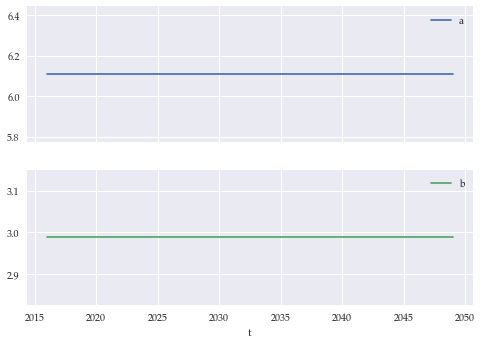

In [9]:
T.get('qD').xs('F',level='s').unstack('n').plot(subplots=True);

Export:

In [10]:
with open(os.path.join(d['data'], T.name), "wb") as file:
    pickle.dump(T,file)